# What this notebook does

The overall goal is to predict the average number of lines of code changed over a k-day span using the prior history of changes over k-day spans. For instance, if k=10, then we would look back over past 10-day averages to predict the next 10-day average. The value of k and the amount to look-back are parameters. We use the following library to build what we need:<p> <code>from keras.preprocessing.sequence import TimeseriesGenerator</code>.<p>
Notice that the 10-day chunks are taken with a sliding window of stride 1. So 12 days will yield [0-9], [1-10] and [2-11], i.e., 3 chunks.

Note that the notebook is set up to treat prediction as a univariate problem where we only look at one column, the lines of code changed (and the average over it). If you wish to explore multivariate models, with more than one column used as input (e.g., include date information), then I suggest you clone this notebook to use its basic structure and then make the changes you wish.

The same is true if you wish to explore a categorization model where there is more than one output. For instance, you may wish to bin the model output and use a softmax layer and one-hot encoding to predict classes (i.e., bins). Again, I would suggest cloning and then editing.

In terms of operation, we first read in a project daily-table that contains for each day of the project (represented as a row) the important information about the project that day (as columns). I expect the set of columns to grow in the future, probably capturing discussion and email for the day. The csv file that you read is produced by a separate notebook.

Once the table is loaded into pandas, some wrangling occurs. We may exclude the first n days of the project, for instance, because it does not reflect the project in its maturity.

We next normalize data.
  

  


## The 3 models explored

Once wrangling is complete, we focus on 3 separate models: (1) a relatively straightforward artificial neural net (ANN), (2) an LSTM, and (3) a 1d convnet.

After each model is tested, information about the test (currently from only the last model in the train-test splits) is packaged up and stored to a json file.

Some preliminary post-hoc binning is done but this could be removed. Enough information is stored in the json file to use another notebook to explore binning.

## Our focus is on deep learning models

Of course, timeseries problems have been around forever and there are a wide-range of prediction models that are possible. See https://www.semanticscholar.org/paper/An-Empirical-Comparison-of-Machine-Learning-Models-Ahmed-Atiya/1f6451ac0572ce0a6a383a25413dadd52cf770ca for at least of a few. Here is a look at non-ML techniques: https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

## Assumptions of this notebook

1. This notebook is being run in google colab. It uses an upload function to bring files from local computer up to colab (i.e., Google Drive). If you wish to run it on your own computer, you will need to change the file reading and writing code. And probably install some libraries.

2. We expect to be able to access this file <code>project + '_feature_set_table_alt_1.csv'</code>  uploaded from your local computer. This file is produced by a separate notebook.

3. We do not save trained models. Howver, it is straightforward to do so. See code below. Note -1 indexes last model tested.<p>
  <pre>
   from keras.models import save, load_model
   models[-1].save('/content/gdrive/My Drive/'+project+'_model_0.h5')
   model_test = load_model('/content/gdrive/My Drive/'+project+'_model_0.h5')
</pre>


In [0]:
import numpy as np
from scipy import stats
import pandas as pd

In [2]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import TimeSeriesSplit

## Parameters for this notebook

Important notes:

* the notebook does not attempt to abstract/parametrize the deep-learning model used. If you want to try something different than what is used, probably safest to copy this notebook and make your changes there.



In [0]:
project = 'petsc'

In [0]:
feature_set_file = project + '_feature_set_table_alt_2.csv'  #alt_2 includes issues

In [0]:
sequence_size = 10 #how many 7-day averages to chunk into one chunk, e.g., 10 => 16 days

In [0]:
averaging_size = 7  #how many days to average over

In [0]:
epochs = 2000

In [0]:
start_day = 0  #what subset of days to model. 0 says start the first day of the project

In [0]:
splits = 3  #how many train-test splits to carry out. A model will be trained and tested for each split

In [11]:
#Need this for later when writing results out

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## First load feature set from file

In [12]:
#need to remove because colab will not replace an existing file but instead tack on a version number instead
!rm $feature_set_file

rm: cannot remove 'petsc_feature_set_table_alt_2.csv': No such file or directory


In [13]:
from google.colab import files
files.upload();

Saving petsc_feature_set_table_alt_2.csv to petsc_feature_set_table_alt_2.csv


In [14]:
feature_set_table = pd.read_csv(feature_set_file)  #produced prior to this notebook
    
len(feature_set_table)

9074

## You can choose a <code>Runtime/Run-after</code> command at this point

All interaction has been completed and code should run until completion.

In [15]:
feature_set_table.head()

,month,day_of_month,day_of_week,year,total_commits,total_loccs,total_messages,total_filenames,total_names,doy,issues
0,9,22,4,1994,1,14,[' Initial revision\n'],"[['a/maint/mkpdir b/maint/mkpdir', 'a/maint/to...",[b'Barry Smith <bsmith@mcs.anl.gov>'],265,[]
1,9,23,5,1994,0,0,[],[],[],266,[]
2,9,24,6,1994,0,0,[],[],[],267,[]
3,9,25,7,1994,0,0,[],[],[],268,[]
4,9,26,1,1994,0,0,[],[],[],269,[]


## Trim feature set down

k is index to start from, i.e., [k:2344]

if k = 0 then whole table (no trimming).

In [0]:
k = start_day  #by starting at day k you are trimming off the first k-1 days

In [17]:
trimmed_table = feature_set_table.iloc[-k:]
trimmed_table.tail()


,month,day_of_month,day_of_week,year,total_commits,total_loccs,total_messages,total_filenames,total_names,doy,issues
9069,7,28,7,2019,3,174,[' tests: add alt files for ksp_ksp_tutoria...,[['a/src/ksp/ksp/examples/tutorials/output/ex7...,"[b'Satish Balay <balay@mcs.anl.gov>', b'Pierre...",209,[]
9070,7,29,1,2019,7,88,[' Missing code around something that needs...,[['a/src/docs/website/documentation/installati...,"[b'BarryFSmith <bsmith@mcs.anl.gov>', b'BarryF...",210,[]
9071,7,30,2,2019,2,50,[' Add PetscIntCast() to check for integer ...,[['a/include/petscsys.h b/include/petscsys.h']...,"[b'Barry Smith <bsmith@mcs.anl.gov>', b'Vaclav...",211,[]
9072,7,31,3,2019,7,50,[' fix compile warnings on arch-linux-pkgs-...,[['a/include/petscsys.h b/include/petscsys.h']...,"[b'Satish Balay <balay@mcs.anl.gov>', b'BarryF...",212,[]
9073,8,1,4,2019,1,3,[' Fix manual pages for MatXXXYBAIJSetPreal...,[['a/src/mat/impls/baij/mpi/mpibaij.c b/src/ma...,[b'Barry Smith <bsmith@mcs.anl.gov>'],213,[]


In [18]:
trimmed_table.head()

,month,day_of_month,day_of_week,year,total_commits,total_loccs,total_messages,total_filenames,total_names,doy,issues
0,9,22,4,1994,1,14,[' Initial revision\n'],"[['a/maint/mkpdir b/maint/mkpdir', 'a/maint/to...",[b'Barry Smith <bsmith@mcs.anl.gov>'],265,[]
1,9,23,5,1994,0,0,[],[],[],266,[]
2,9,24,6,1994,0,0,[],[],[],267,[]
3,9,25,7,1994,0,0,[],[],[],268,[]
4,9,26,1,1994,0,0,[],[],[],269,[]


##Transform into a univariate sequence

A sequence of n-day averages. Uses averaging_size to get n.

In [0]:
averages = []

for i in range(len(trimmed_table) - averaging_size):
  x_average = sum([trimmed_table.loc[j, 'total_loccs'] for j in range(i, i+averaging_size)])/averaging_size
  averages.append(x_average)

In [20]:
uni_averages = np.array(averages)
uni_averages[:10]

array([   2.        ,    0.        ,    0.        , 1077.85714286,
       1077.85714286, 1085.        , 1109.57142857, 1114.14285714,
       1117.57142857, 1117.57142857])

## Now normalize

In [21]:
x_min = uni_averages.min()
x_max = uni_averages.max()
z = x_max - x_min
x_normed = np.array([(val-x_min)/z for val in uni_averages])
x_normed[:10]

array([2.75573192e-05, 0.00000000e+00, 0.00000000e+00, 1.48514267e-02,
       1.48514267e-02, 1.49498457e-02, 1.52884070e-02, 1.53513952e-02,
       1.53986363e-02, 1.53986363e-02])

###Un-Norming function for later

In [0]:
def undo_norm(z, xm):
  return lambda v: v * z + xm
    
unnorm = undo_norm(z,x_min)

In [24]:
unnorm(2.75573192e-05)

1.9999999982592

## Look at rolling averages, etc.

We are not doing anything with smoothing at the moment. However, some data that might be useful if you choose to do some smoothing is plotted.

Also see https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('Solarize_Light2')


data = [(i,v) for i,v in enumerate(uni_averages)]
df = pd.DataFrame(data, columns=['time','data']).set_index('time')



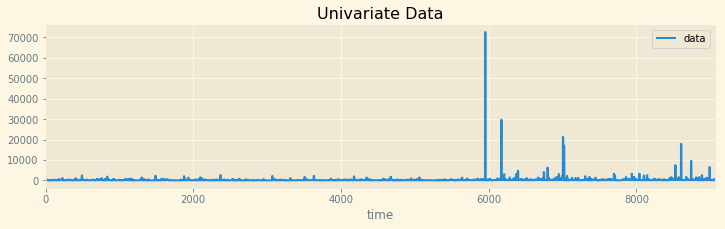

In [26]:
df.plot(figsize=(12,3));
plt.title('Univariate Data');

In [0]:
window = 30
df['z_data'] = (df['data'] - df.data.rolling(window=window).mean()) / df.data.rolling(window=window).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(window)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=window).mean(), 'r', label="rolling mean");
    ax[0].plot(df.data.rolling(window=window).std(), 'y', label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=window).mean(), 'r',label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=window).std(), 'y',label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label=str(window)+" lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=window).mean(), 'r',label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=window).std(), 'y',label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()


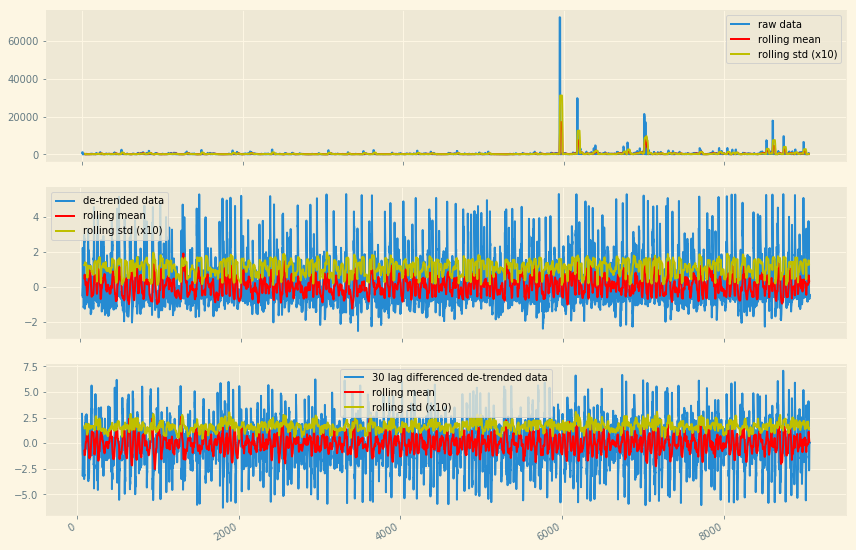

In [28]:
plot_rolling(df)

##See how generator works

Will be using it in setting up input and output during model training.

Important to note that we are using a stride of 1. Only shift k-day lens one day at a time to the right. In particularly, we are not looking at weeks where we would have a stride of 7. Here is tutorial: https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [0]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
# define generator
series = x_normed  #list of 7-day averages using sliding window, e.g., 14 days yields 8 x 7-day averages

generator = TimeseriesGenerator(series, series, length=sequence_size, batch_size=1)

In [31]:
# number of samples
print('Samples: %d' % len(generator))

Samples: 9057


In [32]:
#note stride of only 1

for i in range(2):
	x, y = generator[i]
	print('%s => %s' % (x, y))

[[2.75573192e-05 0.00000000e+00 0.00000000e+00 1.48514267e-02
  1.48514267e-02 1.49498457e-02 1.52884070e-02 1.53513952e-02
  1.53986363e-02 1.53986363e-02]] => [0.00054721]
[[0.         0.         0.01485143 0.01485143 0.01494985 0.01528841
  0.0153514  0.01539864 0.01539864 0.00054721]] => [0.00054721]


### Grab a test value for illustration

In [33]:
test_input = generator[0][0]
test_input

array([[2.75573192e-05, 0.00000000e+00, 0.00000000e+00, 1.48514267e-02,
        1.48514267e-02, 1.49498457e-02, 1.52884070e-02, 1.53513952e-02,
        1.53986363e-02, 1.53986363e-02]])

In [34]:
test_output = generator[0][1]
test_output

array([0.00054721])

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

## Now look at generating train-test splits

Observations: 4535
Training Observations: 2269
Testing Observations: 2266
Observations: 6801
Training Observations: 4535
Testing Observations: 2266
Observations: 9067
Training Observations: 6801
Testing Observations: 2266


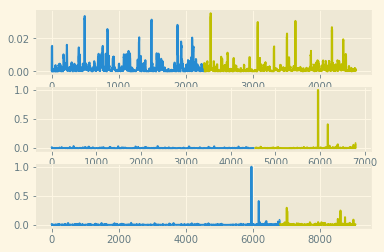

In [36]:
X = [f for f in x_normed]  #use normed_total_loccs column
splits = TimeSeriesSplit(n_splits=splits)  #choosing 3 splits
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
  train = [X[i] for i in train_index]
  test = [X[i] for i in test_index]
  print('Observations: %d' % (len(train) + len(test)))
  print('Training Observations: %d' % (len(train)))
  print('Testing Observations: %d' % (len(test)))
  pyplot.subplot(310 + index)
  pyplot.plot(train)
  pyplot.plot([None for i in train] + [x for x in test], 'y')
  index += 1
pyplot.show()


## First model - straight up ANN

In [0]:
def ann_build_and_train_and_test(train_x, test_x, sequence_size, epochs=1000):
  print('Starting new model construction')
  
  #generate a list of sequences for training 
  print('Generating training feature-set and labels')
  
  generator = TimeseriesGenerator(train_x, train_x, length=sequence_size, batch_size=1)
  model = Sequential()
  model.add(Dense(100, activation='relu', input_dim=sequence_size))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit_generator(generator, steps_per_epoch=1, epochs=epochs, verbose=0)
  
  #test model
  print('Testing model')
  generator = TimeseriesGenerator(test_x, test_x, length=sequence_size, batch_size=1)
  predictions = []
  for  x,y in generator:
    #chunk = np.expand_dims(x, axis=0)
    chunk = x
    yhat = model.predict(chunk, verbose=0)
    predictions.append((yhat, y, abs(yhat-y)))  #(prediction, actual, diff)
  print('model ready to go')
  return (model, predictions)

### Reminder that k models will be trained and tested.

Where k = splits (set at top of notebook).

See graph above for the days that are included for each. Note only the last model takes into account the entire span of days.

In [40]:
import time
t0 = time.time()

ann_models = []
ann_model_predictions = []

for train_indices, test_indices in splits.split(x_normed[:-averaging_size]):
  train_x = [x_normed[i] for i in train_indices]           #Note train_index is actually a list of indices
  test_x = [x_normed[i] for i in test_indices]
  
  print('Building model with these ranges:')
  print('\t Training: ' + str((train_indices[0], train_indices[-1])))
  print('\t Testing:  ' + str((test_indices[0], test_indices[-1])))
  
  the_model, predictions = ann_build_and_train_and_test(train_x,  test_x, sequence_size, epochs)

  ann_model_predictions.append(predictions)  #list of (yhat, actual) for each feature in test
  ann_models.append(the_model)

t1 = time.time()
print(('elapsed time', t1-t0))

Building model with these ranges:
	 Training: (0, 2264)
	 Testing:  (2265, 4529)
Starting new model construction
Generating training feature-set and labels
Testing model
model ready to go
Building model with these ranges:
	 Training: (0, 4529)
	 Testing:  (4530, 6794)
Starting new model construction
Generating training feature-set and labels
Testing model
model ready to go
Building model with these ranges:
	 Training: (0, 6794)
	 Testing:  (6795, 9059)
Starting new model construction
Generating training feature-set and labels
Testing model
model ready to go
('elapsed time', 14.555704593658447)


In [41]:
len(ann_models)

3

###Plot the abs differences bewteen predicted and actual in terms of k-day averages of lines of code changed.

In [42]:
## Plot abs(predicted-actual)

%matplotlib inline
from matplotlib import pyplot as plt


# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print( "Current size:", fig_size)

# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

def basic_plot(value_list, xlabel, ylabel):
  the_mean = np.mean(value_list)
  the_std = np.std(value_list)
  length = len(value_list)
  plt.plot(value_list)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title('mean='+str(the_mean)[:5]+' std='+str(the_std)[:5])
  plt.fill_between(list(range(len(value_list))), [the_mean+the_std]*length, [the_mean-the_std]*length, alpha = 0.1, color='red', edgecolor='green', linewidth=1)
  plt.plot([the_mean+the_std]*length, label='std', linestyle='-', color='green', linewidth=1)
  plt.plot([the_mean]*length, label='Mean', linestyle='--', color='red')
  plt.plot([the_mean-the_std]*length, label='std', linestyle='-', color='green', linewidth=1)
  plt.show()


Current size: [6.0, 4.0]


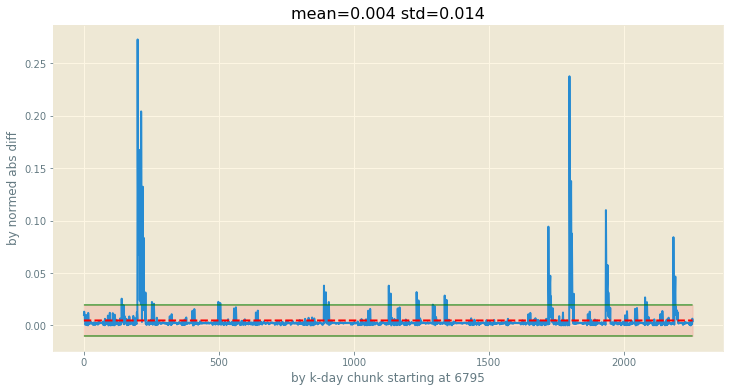

In [43]:
diffs = [d[0] for y,a,d in ann_model_predictions[-1]]  #need [0] to strip array off
basic_plot(diffs, 'by k-day chunk starting at '+str(test_indices[0]), 'by normed abs diff')

### Show for unnormed

Just because it is easier to see actual lines of code on y axis.

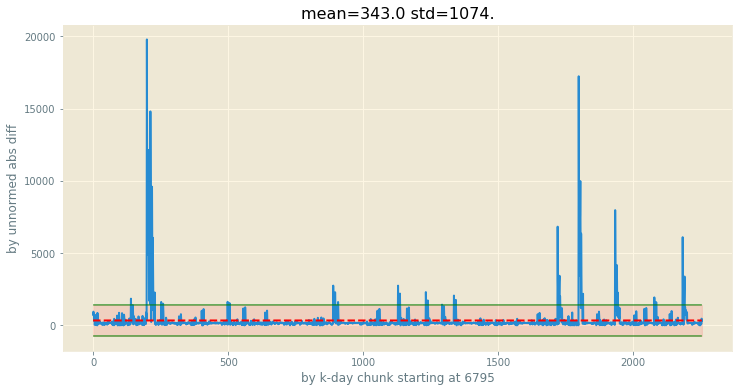

In [44]:
diffs = [unnorm(d[0]) for y,a,d in ann_model_predictions[-1]]  #need [0] to strip array off
basic_plot(diffs, 'by k-day chunk starting at '+str(test_indices[0]), 'by unnormed abs diff')

### Percentage of differences below mean difference

In [45]:
the_mean = np.mean(diffs)
sum([1 for d in diffs if d<the_mean])/len(diffs)

0.8780487804878049

### Mean Squared Error

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error([unnorm(a[0]) for y,a,d in ann_model_predictions[-1]], [unnorm(y[0]) for y,a,d in ann_model_predictions[-1]])

1271460.6741831973

###Check out binning

Post-hoc look at binning. Bin both predicted and actual and see how they match up.

Note could also set up model to be categorical and have it predict bins directly through one-hot encoding and softmax final layer.

In [0]:
normed_mean = np.mean(x_normed)
normed_std = np.std(x_normed)

bins = [normed_mean, normed_mean+normed_std, max(x_normed)]  #below average, above average, way above average

In [0]:
binned_results = []
for y,a,d in ann_model_predictions[-1]:
  for j,b in enumerate(bins):
    if y<b:
      yb = j
      break
      
  for j,b in enumerate(bins):
    if a<b:
      ab = j
      break
      
  binned_results.append((yb, ab))
      
  

In [49]:
for i in range(len(bins)):
  for j in range(len(bins)):
    print((i,j,binned_results.count((i,j))))

(0, 0, 1173)
(0, 1, 46)
(0, 2, 0)
(1, 0, 405)
(1, 1, 558)
(1, 2, 22)
(2, 0, 5)
(2, 1, 1)
(2, 2, 45)


### Way to read above

Take this set of results as an example.

<pre>
(0, 0, 295)
(0, 1, 34)
(0, 2, 3)
(1, 0, 47)
(1, 1, 140)
(1, 2, 5)
(2, 0, 0)
(2, 1, 10)
(2, 2, 38)
</pre>

If you view predicting the spikes (bin 2) as key, then the results show false negative 3+5 times (14%), perhaps the 3 being the worst: predicting below avearage and actual spike instead. It shows false positives 0+10 times (18%). It is correct 38 times ( 68%).

Code below gives accuracy for each bin.

In [50]:

for i in range(len(bins)):
  errors = 0
  for j in range(len(bins)):
    if i==j:
      correct = binned_results.count((i,i))
      continue
    errors += binned_results.count((i,j))
  print((i, correct/(correct+errors)))
  
  

(0, 0.9622641509433962)
(1, 0.566497461928934)
(2, 0.8823529411764706)


### Full binning accuracy

In [51]:
sum([1 for y,a in binned_results if y==a])/len(binned_results)  #percentage correct binning

0.7875831485587583

## Store results

In [52]:
ann_models[-1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 101       
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%capture --no-stderr x
ann_models[-1].summary()


In [54]:
description = x.stdout
description

'_________________________________________________________________\nLayer (type)                 Output Shape              Param #   \n=================================================================\ndense_29 (Dense)             (None, 100)               1100      \n_________________________________________________________________\ndense_30 (Dense)             (None, 1)                 101       \n=================================================================\nTotal params: 1,201\nTrainable params: 1,201\nNon-trainable params: 0\n_________________________________________________________________\n'

In [0]:
ann_model_results = {'project': project}
ann_model_results['model'] =  description
ann_model_results['epochs'] = epochs
ann_model_results['sequence_size'] = sequence_size
ann_model_results['averaging_size'] = averaging_size
ann_model_results['results'] = [(tup[0].tolist()[0][0], tup[1].tolist()[0], tup[2].tolist()[0][0]) for tup in ann_model_predictions[-1]]  #remove numpy wrappers

In [0]:
from datetime import datetime
now = datetime.now() # current date and time
date_time = now.strftime("%m_%d_%Y_%H_%M_%S")

ann_model_results['time_stamp'] = date_time

In [0]:
import json

file_path = '/content/gdrive/My Drive/model_results/'+project+'_ann_results_'+date_time+'.json'

json = json.dumps(ann_model_results)
f = open(file_path,"w")
f.write(json)
f.close()

In [0]:
ann_models[-1].save('/content/gdrive/My Drive/model_results/'+project+'_ann_model_'+date_time+'.h5')
#model_test = load_model('/content/gdrive/My Drive/'+project+'_model_0.h5')

## LSTM next up



In [0]:
  '''
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(np_features.shape[1], np_features.shape[2])))  #e.g., 30x4
  model.add(Dropout(0.2))  
  model.add(LSTM(units=50, return_sequences=True))  
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))  
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))  #return_sequences=False by default
  model.add(Dropout(0.2))  
  model.add(Dense(units = 1))  #defaults to linear activation function
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  '''

"\nmodel = Sequential()\nmodel.add(LSTM(units=50, return_sequences=True, input_shape=(np_features.shape[1], np_features.shape[2])))  #e.g., 30x4\nmodel.add(Dropout(0.2))  \nmodel.add(LSTM(units=50, return_sequences=True))  \nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=50, return_sequences=True))  \nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=50))  #return_sequences=False by default\nmodel.add(Dropout(0.2))  \nmodel.add(Dense(units = 1))  #defaults to linear activation function\nmodel.compile(optimizer = 'adam', loss = 'mean_squared_error')\n"

In [0]:
def lstm_build_and_train_and_test(train_x, test_x, sequence_size, epochs=1000):
  print('Starting new model construction')
  
  n_features = 1
  w_series = np.array(train_x).reshape((len(train_x), n_features))
  #generate a list of sequences for training 
  print('Generating training feature-set and labels')
                            
  n_input = sequence_size
  generator = TimeseriesGenerator(w_series, w_series, length=n_input, batch_size=1)
                            
# define model
  model = Sequential()
  model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit_generator(generator, steps_per_epoch=1, epochs=epochs, verbose=0)
  
  #test model
  print('Testing model')
  generator = TimeseriesGenerator(test_x, test_x, length=sequence_size, batch_size=1)
  predictions = []
  for  x,y in generator:
    #chunk = np.expand_dims(x, axis=0)
    x_input = x.reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=0)
    predictions.append((yhat, y, abs(yhat-y)))  #(prediction, actual, diff)
  print('model ready to go')
  return (model, predictions)

In [61]:
lstm_models = []
lstm_model_predictions = []

for train_indices, test_indices in splits.split(x_normed[:-averaging_size]):
  train_x = [x_normed[i] for i in train_indices]           #Note train_index is actually a list of indices
  test_x = [x_normed[i] for i in test_indices]
  
  print('Building model with these ranges:')
  print('\t Training: ' + str((train_indices[0], train_indices[-1])))
  print('\t Testing:  ' + str((test_indices[0], test_indices[-1])))
  
  the_model, predictions = lstm_build_and_train_and_test(train_x,  test_x, sequence_size)

  lstm_model_predictions.append(predictions)  #list of (yhat, actual) for each feature in test
  lstm_models.append(the_model)


Building model with these ranges:
	 Training: (0, 2264)
	 Testing:  (2265, 4529)
Starting new model construction
Generating training feature-set and labels


W0801 20:54:47.183722 139887015524224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Testing model
model ready to go
Building model with these ranges:
	 Training: (0, 4529)
	 Testing:  (4530, 6794)
Starting new model construction
Generating training feature-set and labels
Testing model
model ready to go
Building model with these ranges:
	 Training: (0, 6794)
	 Testing:  (6795, 9059)
Starting new model construction
Generating training feature-set and labels
Testing model
model ready to go


### Plot the differences (between predicted and actual)

In [0]:
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

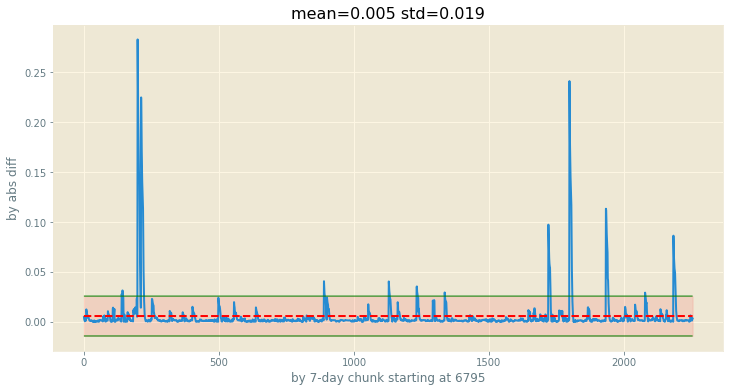

In [63]:
diffs = [d[0] for y,a,d in lstm_model_predictions[-1]]  #need [0] to strip array off
basic_plot(diffs, 'by 7-day chunk starting at '+str(test_indices[0]), 'by abs diff')

### Show for unnormed

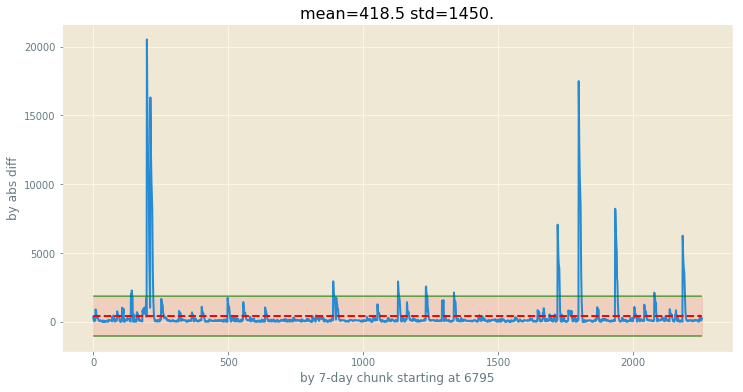

In [64]:
diffs = [unnorm(d[0]) for y,a,d in lstm_model_predictions[-1]]  #need [0] to strip array off
basic_plot(diffs, 'by 7-day chunk starting at '+str(test_indices[0]), 'by abs diff')

### Percentage of differences below mean difference

In [65]:
the_mean = np.mean(diffs)
sum([1 for d in diffs if d<the_mean])/len(diffs)

0.8501108647450111

In [66]:
mean_squared_error([unnorm(a[0]) for y,a,d in lstm_model_predictions[-1]], [unnorm(y[0]) for y,a,d in lstm_model_predictions[-1]])

2278187.55526833

###Check out binning

Post-hoc look at binning. Bin both predicted and actual and see how they match up.

In [0]:
normed_mean = np.mean(x_normed)
normed_std = np.std(x_normed)

bins = [normed_mean, normed_mean+normed_std, max(x_normed)]  #below average, moderately above average, way above average

In [0]:
binned_results = []
for y,a,d in lstm_model_predictions[-1]:
  for j,b in enumerate(bins):
    if y<b:
      yb = j
      break
      
  for j,b in enumerate(bins):
    if a<b:
      ab = j
      break
      
  binned_results.append((yb, ab))
      
  

In [69]:
for i in range(len(bins)):
  for j in range(len(bins)):
    print((i,j,binned_results.count((i,j))))

(0, 0, 1468)
(0, 1, 328)
(0, 2, 7)
(1, 0, 102)
(1, 1, 276)
(1, 2, 34)
(2, 0, 13)
(2, 1, 1)
(2, 2, 26)


In [70]:
for i in range(len(bins)):
  errors = 0
  for j in range(len(bins)):
    if i==j:
      correct = binned_results.count((i,i))
      continue
    errors += binned_results.count((i,j))
  print((i, correct/(correct+errors)))

(0, 0.8141985579589573)
(1, 0.6699029126213593)
(2, 0.65)


In [71]:
sum([1 for y,a in binned_results if y==a])/len(binned_results)  #percentage correct binning

0.7849223946784922

In [72]:
lstm_models[-1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%capture --no-stderr x
lstm_models[-1].summary()


In [74]:
description = x.stdout
description

'_________________________________________________________________\nLayer (type)                 Output Shape              Param #   \n=================================================================\nlstm_3 (LSTM)                (None, 100)               40800     \n_________________________________________________________________\ndense_33 (Dense)             (None, 1)                 101       \n=================================================================\nTotal params: 40,901\nTrainable params: 40,901\nNon-trainable params: 0\n_________________________________________________________________\n'

In [0]:
lstm_model_results = {'project': project}
lstm_model_results['model'] =  description
lstm_model_results['epochs'] = epochs
lstm_model_results['sequence_size'] = sequence_size
lstm_model_results['averaging_size'] = averaging_size
lstm_model_results['results'] = [(tup[0].tolist()[0][0], tup[1].tolist()[0], tup[2].tolist()[0][0]) for tup in lstm_model_predictions[-1]]  #remove numpy wrappers

In [0]:

now = datetime.now() # current date and time
date_time = now.strftime("%m_%d_%Y_%H_%M_%S")

lstm_model_results['time_stamp'] = date_time

In [0]:
import json

file_path = '/content/gdrive/My Drive/model_results/'+project+'_lstm_results_'+date_time+'.json'

json = json.dumps(ann_model_results)
f = open(file_path,"w")
f.write(json)
f.close()

In [0]:
lstm_models[-1].save('/content/gdrive/My Drive/model_results/'+project+'_lstm_model_'+date_time+'.h5')
#model_test = load_model('/content/gdrive/My Drive/'+project+'_model_0.h5')

## CNN up next

use 1d convnet.

I have a particular interest in convnets and their foundation for transfer learning. My conjecture is that we can train a set of features that recognize patterns across projects and then reuse by tacking on the last layers that fit a specific project.

In [0]:
  #Some ideas to play around with later. Code below uses categorical prediction as opposed to regression.
  
  '''
  model = Sequential()
  model.add(Conv1D(filters=sequence_size, kernel_size=3, activation='relu', input_shape=(np_features.shape[1], np_features.shape[2])))
  model.add(Conv1D(filters=sequence_size, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(len(bins), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  
  #see https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
  model = Sequential()
  model.add(Conv1D(sequence_size, 7, activation='relu', input_shape=(sequence_size, averaging_size)))
  model.add(Dropout(0.5))  
  model.add(Conv1D(sequence_size, 7, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(Dropout(.5))  
  model.add(Conv1D(2*sequence_size, 3, activation='relu'))
  model.add(Dropout(0.5))  
  model.add(Conv1D(2*sequence_size, 3, activation='relu'))
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(len(bins), activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
                
 '''

"\nmodel = Sequential()\nmodel.add(Conv1D(filters=sequence_size, kernel_size=3, activation='relu', input_shape=(np_features.shape[1], np_features.shape[2])))\nmodel.add(Conv1D(filters=sequence_size, kernel_size=3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Flatten())\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(len(bins), activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\n\n#see https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf\nmodel = Sequential()\nmodel.add(Conv1D(sequence_size, 7, activation='relu', input_shape=(sequence_size, averaging_size)))\nmodel.add(Dropout(0.5))  \nmodel.add(Conv1D(sequence_size, 7, activation='relu'))\nmodel.add(MaxPooling1D(3))\nmodel.add(Dropout(.5))  \nmodel.add(Conv1D(2*sequence_size, 3, activation='relu'))\nmodel.add(Dropout(0.5))  \nmodel.add(Conv1D(2*seque

In [0]:
def cnn_build_and_train_and_test(train_x, test_x, sequence_size, epochs=1000):
  print('Starting new model construction')
  
  n_features = 1
  w_series = np.array(train_x).reshape((len(train_x), n_features))
  #generate a list of sequences for training 
  print('Generating training feature-set and labels')
                            
  n_steps = sequence_size
  generator = TimeseriesGenerator(w_series, w_series, length=sequence_size, batch_size=1)  #0-29=>30, 1-30=>31, etc
                            
# define model
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=5, activation= 'relu' , input_shape=(n_steps, n_features)))
  model.add(Dropout(0.5)) 
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(.5))
  model.add(Flatten())
  model.add(Dense(50, activation= 'relu' ))
  model.add(Dropout(.5))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit_generator(generator, steps_per_epoch=1, epochs=epochs, verbose=0)
  
  #test model
  print('Testing model')
  generator = TimeseriesGenerator(test_x, test_x, length=sequence_size, batch_size=1)
  predictions = []
  for  x,y in generator:
    #chunk = np.expand_dims(x, axis=0)
    x_input = x.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    predictions.append((yhat, y, abs(yhat-y)))  #(prediction, actual, diff)
  print('model ready to go')
  return (model, predictions)

In [80]:
cnn_models = []
cnn_model_predictions = []

for train_indices, test_indices in splits.split(x_normed[:-averaging_size]):
  train_x = [x_normed[i] for i in train_indices]           #Note train_index is actually a list of indices
  test_x = [x_normed[i] for i in test_indices]
  
  print('Building model with these ranges:')
  print('\t Training: ' + str((train_indices[0], train_indices[-1])))
  print('\t Testing:  ' + str((test_indices[0], test_indices[-1])))
  
  the_model, predictions = cnn_build_and_train_and_test(train_x,  test_x, sequence_size, epochs)

  cnn_model_predictions.append(predictions)  #list of (yhat, actual) for each feature in test
  cnn_models.append(the_model)


W0801 20:56:54.216268 139887015524224 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0801 20:56:54.234110 139887015524224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Building model with these ranges:
	 Training: (0, 2264)
	 Testing:  (2265, 4529)
Starting new model construction
Generating training feature-set and labels
Testing model
model ready to go
Building model with these ranges:
	 Training: (0, 4529)
	 Testing:  (4530, 6794)
Starting new model construction
Generating training feature-set and labels
Testing model
model ready to go
Building model with these ranges:
	 Training: (0, 6794)
	 Testing:  (6795, 9059)
Starting new model construction
Generating training feature-set and labels
Testing model
model ready to go


In [0]:
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

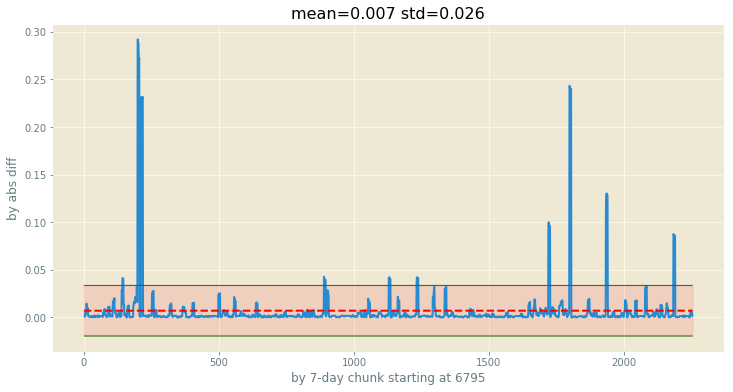

In [82]:
diffs = [d[0] for y,a,d in cnn_model_predictions[-1]]  #need [0] to strip array off
basic_plot(diffs, 'by 7-day chunk starting at '+str(test_indices[0]), 'by abs diff')

### Show for unnormed

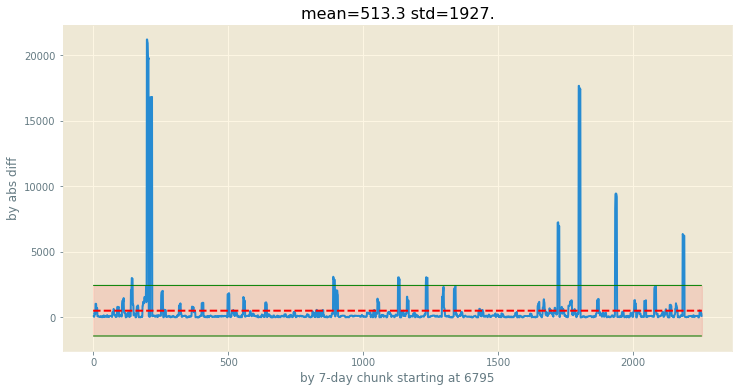

In [83]:
diffs = [unnorm(d[0]) for y,a,d in cnn_model_predictions[-1]]  #need [0] to strip array off
basic_plot(diffs, 'by 7-day chunk starting at '+str(test_indices[0]), 'by abs diff')

### Percentage of differences below mean difference

In [84]:
the_mean = np.mean(diffs)
sum([1 for d in diffs if d<the_mean])/len(diffs)

0.8514412416851441

In [85]:
mean_squared_error([unnorm(a[0]) for y,a,d in cnn_model_predictions[-1]], [unnorm(y[0]) for y,a,d in cnn_model_predictions[-1]])

3979654.786788905

###Check out binning

Post-hoc look at binning. Bin both predicted and actual and see how they match up.

In [0]:
normed_mean = np.mean(x_normed)
normed_std = np.std(x_normed)

bins = [normed_mean, normed_mean+normed_std, max(x_normed)]  #below average, moderately above average, way above average

In [0]:
binned_results = []
for y,a,d in cnn_model_predictions[-1]:
  for j,b in enumerate(bins):
    if y<b:
      yb = j
      break
      
  for j,b in enumerate(bins):
    if a<b:
      ab = j
      break
      
  binned_results.append((yb, ab))
      
  

In [88]:
for i in range(len(bins)):
  for j in range(len(bins)):
    print((i,j,binned_results.count((i,j))))

(0, 0, 1583)
(0, 1, 605)
(0, 2, 66)
(1, 0, 0)
(1, 1, 0)
(1, 2, 1)
(2, 0, 0)
(2, 1, 0)
(2, 2, 0)


In [89]:
for i in range(len(bins)):
  errors = 0
  for j in range(len(bins)):
    if i==j:
      correct = binned_results.count((i,i))
      continue
    errors += binned_results.count((i,j))
  print((i, correct/(correct+errors)))
  
  

(0, 0.7023070097604259)
(1, 0.0)


ZeroDivisionError: ignored

In [90]:
sum([1 for y,a in binned_results if y==a])/len(binned_results)  #percentage correct binning

0.7019955654101996

In [0]:
%%capture --no-stderr x
cnn_models[-1].summary()


In [0]:
description = x.stdout
description

'_________________________________________________________________\nLayer (type)                 Output Shape              Param #   \n=================================================================\nconv1d_3 (Conv1D)            (None, 6, 64)             384       \n_________________________________________________________________\ndropout_7 (Dropout)          (None, 6, 64)             0         \n_________________________________________________________________\nmax_pooling1d_3 (MaxPooling1 (None, 3, 64)             0         \n_________________________________________________________________\ndropout_8 (Dropout)          (None, 3, 64)             0         \n_________________________________________________________________\nflatten_3 (Flatten)          (None, 192)               0         \n_________________________________________________________________\ndense_14 (Dense)             (None, 50)                9650      \n_____________________________________________________________

In [0]:
cnn_model_results = {'project': project}
cnn_model_results['model'] =  description
cnn_model_results['epochs'] = epochs
cnn_model_results['sequence_size'] = sequence_size
cnn_model_results['averaging_size'] = averaging_size
cnn_model_results['results'] = [(tup[0].tolist()[0][0], tup[1].tolist()[0], tup[2].tolist()[0][0]) for tup in cnn_model_predictions[-1]]  #remove numpy wrappers

In [0]:

now = datetime.now() # current date and time
date_time = now.strftime("%m_%d_%Y_%H_%M_%S")

cnn_model_results['time_stamp'] = date_time

In [0]:
import json

file_path = '/content/gdrive/My Drive/model_results/'+project+'_cnn_results_'+date_time+'.json'

json = json.dumps(cnn_model_results)
f = open(file_path,"w")
f.write(json)
f.close()

In [0]:
cnn_models[-1].save('/content/gdrive/My Drive/model_results/'+project+'_cnn_model_'+date_time+'.h5')
#model_test = load_model('/content/gdrive/My Drive/'+project+'_model_0.h5')

## End of main section

Things below here just snippets to play around with.

In [0]:
fee_fie_foe()   #used to cause error and stop notebook here

NameError: ignored

In [0]:
results_table.to_csv('/content/gdrive/My Drive/'+project+'_cnn_results_'+date_time+'.csv', index=False)

In [0]:
# summarize the balance of classes in an output variable column
def class_breakdown(data):
  # convert the numpy array into a dataframe
  df = pd.DataFrame(data)
  # group data by the class value and calculate the number of rows
  counts = df.groupby(0).size()
  # retrieve raw rows
  counts = counts.values
  # summarize
  print('Bin sizes - training:')
  for i in range(len(counts)):
    percent = counts[i] / len(df) * 100
    print( 'Class=%d, total=%d, percentage=%.3f'  % (i+1, counts[i], percent))

In [0]:
def do_binning_and_ohe_of_y(y_data, bins):
  if not bins: return y_data  #if bins empty just return y_data
  binned_labels = []
  for raw in y_data:
    for j,b in enumerate(bins):
      if raw <= b:
        binned_labels.append(j)
        break
    else:
      print((raw, bins))
      raise Exception()
      
  class_breakdown(binned_labels)  #print out percentages
  
  #may not see all bins given train-test splits so need to add them in
  missing_set = set(list(range(len(bins))))-set(binned_labels)
  if missing_set:
    #replacing actual values at very end - a kludge
    n_missing = len(missing_set)
    binned_labels = binned_labels + list(missing_set)
    print(('adding missing bins during training: ', missing_set))
    np_labels = to_categorical(binned_labels)  #one hot encode using keras
    np_labels = np_labels[:-n_missing]  #remove the ones that got tacked on
  else:
    np_labels = to_categorical(binned_labels)  #one hot encode using keras function

  return np_labels

## Auto Grid Search example

See https://stackoverflow.com/a/46918197

Try later.

In [0]:
bin0 = 0  #<=0
bin1 = the_std  #<= 1*sigma
bin2 = 2*the_std #<= 2*sigma
bin3 = max(averaged_labels)  #<= the max
bins = [bin0, bin1, bin2, bin3]
bins

In [0]:
def curry_bin(bins):
  def produce_bin(chunk):
    avg = create_average(chunk)
    for i,b in enumerate(bins):
      if avg <= b: return i

    print('problem with binning: ' + str(val))
    raise Exception
    
  return produce_bin

In [0]:
get_bin = curry_bin(bins)

##Note to self

THere is a 0 at 1773 but not showing up when do splits on test data.

Need to track down why not showing up on middle test split. Plot shows no 0 bins seen.

Found problem: middle is cut off in middle of the 7 day 0 run. So never see the full 7 0s.

In [0]:
binned_averages = []
for i in range(chunk_size, len(just_commits)):  
    next_chunk = just_commits[i:i+look_ahead_size]
    the_average = get_average(next_chunk)
    for j,b in enumerate(bins):
      if the_average <= b:
        the_bin = j
        break
    binned_averages.append(the_bin)

In [0]:
pie_labels = ['bin 0 <= '+'%.2f'%(bin0), 'bin 1 <= '+'%.2f'%(bin1), 'bin 2 <= '+'%.2f'%(bin2), 'bin 3 <= '+'%.2f'%(bin3)]
sizes = [binned_averages.count(0),binned_averages.count(1),binned_averages.count(2),binned_averages.count(3)]

plt.pie(sizes, labels=pie_labels, autopct='%1.1f%%',  shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

So if we always predicted bin 1 we would be accurate 39% of time.

In [0]:
basic_plot(binned_averages, 'binned average by days', 'Commits per bin (0-3)')

## Important note

The lonely bin 0 on right is lost when splitting. By accident, the split happens within the week with all 0s. So lose it.

And from above, we can go all the way back to around day 900 if ignore the one data point at 1743.

## Manual grid-search

https://www.mikulskibartosz.name/nested-cross-validation-in-time-series-forecasting-using-scikit-learn-and-statsmodels/

In [0]:
#Try on training set for giggles
check_predictions = []

for  i,chunk in enumerate(scaled_features_set):
  chunk = np.reshape(chunk, (1, scaled_features_set.shape[1], 1))
  yhat = model.predict(chunk, verbose=0)
  check_predictions.append((yhat, scaled_labels[i], abs(yhat-scaled_labels[i])))
